# Object Predictions with Difficulty Manipulation (Exp1)

In [1]:
#TRIGGER INFO...
# The BaseTriggers are as follows (these are used for the localiser):

# Target1  (Easy)     -> 1
# Target2  (Hard)     -> 2
# CueT1               -> 3
# CueT2               -> 4
# NeutralS2s          -> 5:8 (4 in total)
# NeutralS1s          -> 9:12 (4 in total)


# baseTrigger + 20    -> CueValid                  e.g. Cue is followed by appropriate item (cue->target/cue-control)
# baseTrigger + 40    -> CueInvalid                e.g. Cue is followed by any other item
# baseTrigger + 60    -> NoCue                     e.g. S1 was not a cue
# baseTrigger + 80    -> S2Expected                e.g. S2 was preceded by valid cue (cue-target)
# baseTrigger + 100   -> S2Unexpected_crit         e.g. S2 was crit item preceded by no cue
# baseTrigger + 120   -> S2Unexpected_neut         e.g. S2 was neutral item preceded by no cue
# baseTrigger + 140   -> S2Expected_invalid        e.g. S2 was preceded by wrong cue (either wrongCue -> crit / cue -> neutralItem)

# CatchTrialEasy      -> 151
# CatchTrialHard      -> 152

# Response_L          -> 180
# Response_R          -> 181

# TrialStart          -> 200
# MaskOnset           -> 210

# Set Up

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: %90 !important;}</style>"))

import mne
mne.sys_info()

Platform:      Linux-4.15.0-64-generic-x86_64-with-debian-stretch-sid
Python:        2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15)  [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Executable:    /home/sage/anaconda2/bin/python
CPU:           x86_64: 8 cores
Memory:        31.4 GB

mne:           0.17.dev0
numpy:         1.12.1 {lapack=mkl_intel_lp64, blas=mkl_intel_lp64}
scipy:         0.19.0
matplotlib:    2.0.2 {backend=module://ipykernel.pylab.backend_inline}

sklearn:       0.18.1
nibabel:       Not found
mayavi:        Not found
pycuda:        Not found
skcuda:        Not found
pandas:        0.20.1


In [2]:
#Load import packages
%matplotlib inline
%config InlineBackend.figure_format='retina'


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import scipy.ndimage
import copy
import os

from glob import glob


mne.set_log_level(False)
from mne.epochs import equalize_epoch_counts
from mne.time_frequency import tfr_morlet, tfr_multitaper, tfr_stockwell
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test

In [3]:
# set experimental path
insource   = '/home/sage/Dropbox/Sage/Hbaws28/Projects/TaskDemand/Analysis/Data/EEGLab/'
sourceloc  = '/home/sage/Dropbox/Sage/Hbaws28/Projects/TaskDemand/Analysis/Data/Python/'

# set montage file
montage = sourceloc + "montage/m.elp"

# make in and out templates for files
in_template  = insource + "{}.set"
out_template = sourceloc + "{1}/{0}-{1}.fif"

# set colors
easyColor = '#6696ED'
diffColor = "#1A1A71"
neutColor = '#CCCCCC'

# make event ids
keys     = ['Easy Cue Valid', 'Difficult Cue Valid', 'Easy Cue Invalid', 'Difficult Cue Invalid', 
           'Neutral Cue1', 'Neutral Cue2', 'Neutral Cue3', 'Neutral Cue4']
values   = [23, 24, 43, 44, 71, 72, 73, 74]
event_ids = dict(zip(keys, values))

# define bad subjects or subjects that already were preprocessed
bad_subjs = {}


# make dictonary of of good subjects
subjs = {file.split("/")[-1].split(".")[0]
              for file in glob(insource + "/*task.set")}

if bool(bad_subjs): 
    subjs = list(sorted(list(subjs - bad_subjs)))
else: 
    subjs = list(sorted(list(subjs)))    
    
# return the amount of subjects and the list of subjects
numSubs = len(subjs)
print(numSubs)
subjs

30


['s01_task',
 's02_task',
 's03_task',
 's04_task',
 's05_task',
 's06_task',
 's07_task',
 's08_task',
 's09_task',
 's10_task',
 's11_task',
 's12_task',
 's13_task',
 's14_task',
 's15_task',
 's16_task',
 's17_task',
 's19_task',
 's20_task',
 's21_task',
 's22_task',
 's23_task',
 's24_task',
 's25_task',
 's27_task',
 's28_task',
 's29_task',
 's30_task',
 's31_task',
 's32_task']

# ERPs

In [4]:
#Okay now load the epochs and combine the cue conditions

conds     = ['Easy Cue', 'Difficult Cue', 'Neutral Cue']
triggers  = [30, 40, 50]
event_ids = dict(zip(conds, triggers))

# load the epoched data
all_epochs = []
for ii, name in enumerate(sorted(subjs)):
    print('starting ' + name)
    if name not in bad_subjs:
        epochs = mne.read_epochs(out_template.format(name, "arvepo"), verbose='error')
        epochs.events[np.in1d(epochs.events[:,2], [71,72,73,74]),2] = 50 #combine all the neutral cue trials
        epochs.events[np.in1d(epochs.events[:,2], [23, 43]),2]      = 30 #combine the easy cue trials
        epochs.events[np.in1d(epochs.events[:,2], [24, 44]),2]      = 40 #and the difficult cue trials
                
        epochs.event_id = event_ids
        epochs.equalize_event_counts(event_ids=event_ids)
        epochs.filter(l_freq= None, h_freq=40, fir_design="firwin")
        print(epochs)
        all_epochs.append(epochs)
print(len(all_epochs))

# get the avarage for each condition per subject
all_evokeds = {cond: [epochs[cond].average() for epochs in all_epochs] for cond in conds}
print(len(all_evokeds))

# Now we should look at the contrasts, here we can subtract the control from each of the conditions of interest...
event_id_conds  = {'Easy Cue': 30, 'Difficult Cue': 40}
conds           = ['Easy Cue', 'Difficult Cue']


contrasts = {cond: [mne.combine_evoked([all_evokeds[cond][sub], - all_evokeds['Neutral Cue'][sub]], 
                           weights = 'equal') for sub in range(numSubs)] for cond in conds}

interaction = [mne.combine_evoked([contrasts['Difficult Cue'][sub], - contrasts['Easy Cue'][sub]], 
                           weights = 'equal') for sub in range(numSubs)]

starting s01_task
<EpochsFIF  |   636 events (all good), -0.2 - 0.75 sec, baseline [-0.2, 0], ~56.7 MB, data loaded,
 'Difficult Cue': 212
 'Easy Cue': 212
 'Neutral Cue': 212>
starting s02_task
<EpochsFIF  |   669 events (all good), -0.2 - 0.75 sec, baseline [-0.2, 0], ~59.6 MB, data loaded,
 'Difficult Cue': 223
 'Easy Cue': 223
 'Neutral Cue': 223>
starting s03_task
<EpochsFIF  |   651 events (all good), -0.2 - 0.75 sec, baseline [-0.2, 0], ~58.0 MB, data loaded,
 'Difficult Cue': 217
 'Easy Cue': 217
 'Neutral Cue': 217>
starting s04_task
<EpochsFIF  |   594 events (all good), -0.2 - 0.75 sec, baseline [-0.2, 0], ~53.0 MB, data loaded,
 'Difficult Cue': 198
 'Easy Cue': 198
 'Neutral Cue': 198>
starting s05_task
<EpochsFIF  |   627 events (all good), -0.2 - 0.75 sec, baseline [-0.2, 0], ~55.9 MB, data loaded,
 'Difficult Cue': 209
 'Easy Cue': 209
 'Neutral Cue': 209>
starting s06_task
<EpochsFIF  |   645 events (all good), -0.2 - 0.75 sec, baseline [-0.2, 0], ~57.5 MB, data loaded

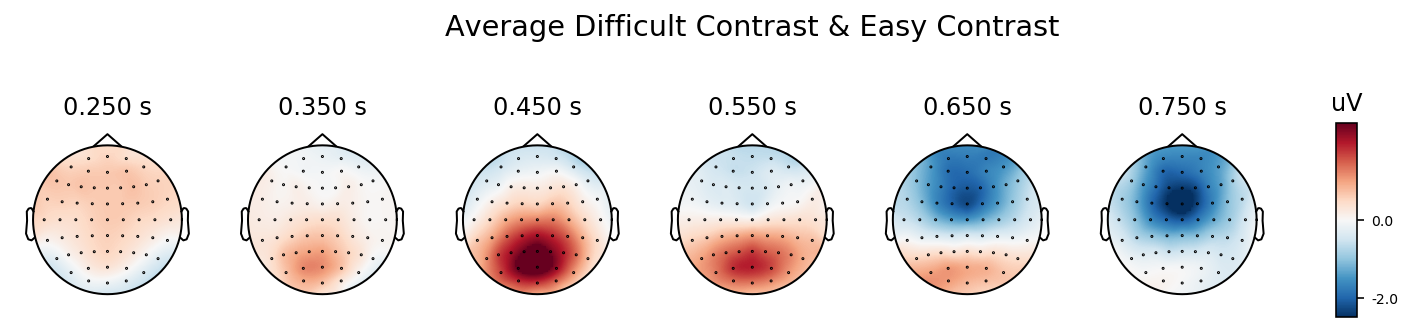

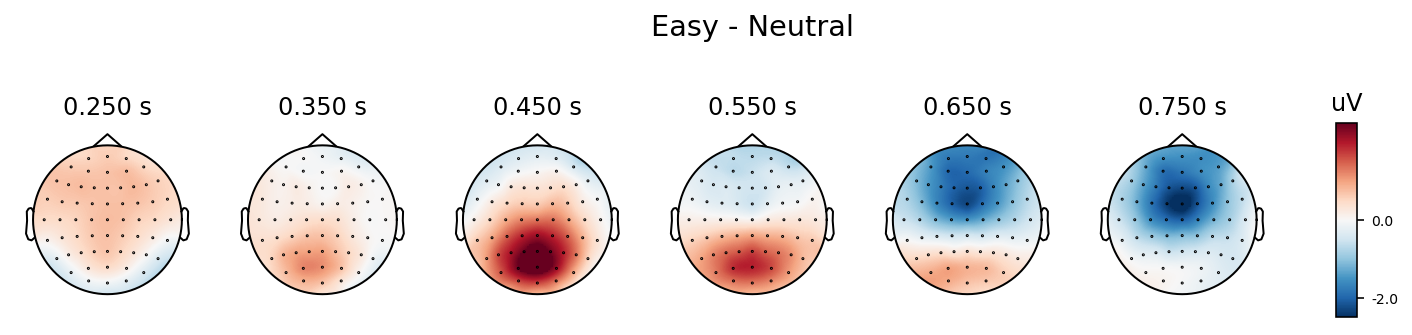

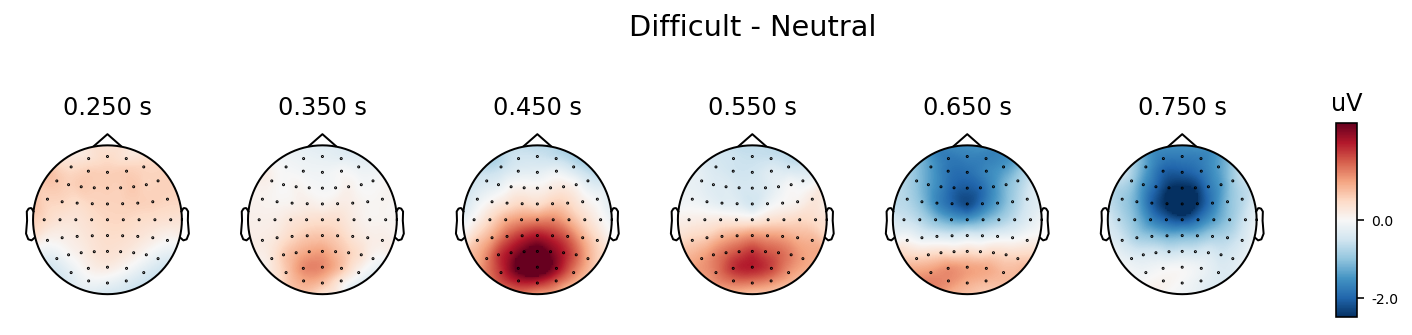

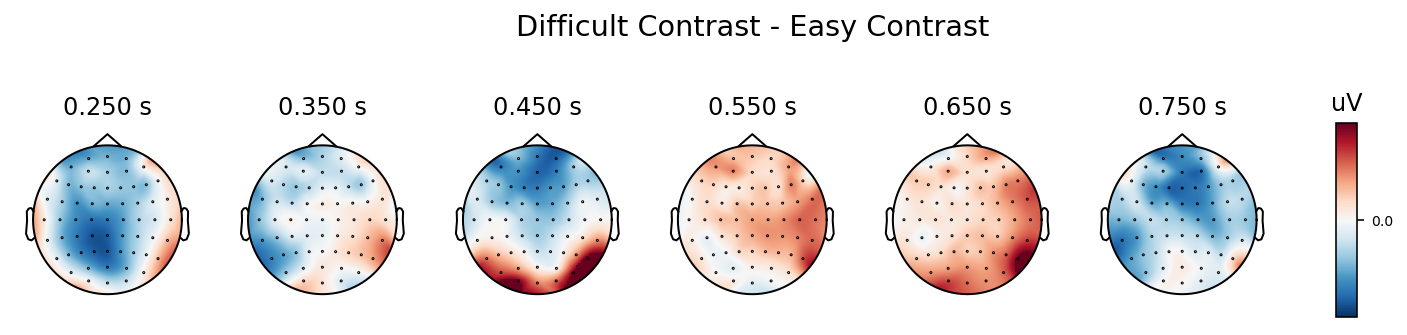

In [5]:
#Create an average across subjects in order to plot the topo
subNum    = 0
easy_data = []
diff_data = []
int_data  = []
avg_data  = []
plotAll   = True
times     = epochs.times


if plotAll:
    for sub in range(numSubs):    
        easy_data.append(contrasts['Easy Cue'][sub].data);
        diff_data.append(contrasts['Difficult Cue'][sub].data);
        int_data.append(interaction[sub].data);
        avg_data.append(np.mean([contrasts['Easy Cue'][sub].data, contrasts['Difficult Cue'][sub].data],0))

    easy_avg = np.mean(easy_data,0)
    diff_avg = np.mean(diff_data,0)
    int_avg  = np.mean(int_data,0)
    avg_avg  = np.mean(avg_data,0)


    #Create a copy of the evoked structure and then replace the data witht the average data
    easy_evoked = copy.deepcopy(contrasts['Easy Cue'][0])
    diff_evoked = copy.deepcopy(contrasts['Difficult Cue'][0])
    int_evoked  = copy.deepcopy(interaction[0])
    avg_evoked  = copy.deepcopy(contrasts['Easy Cue'][0])

    easy_evoked.data = easy_avg
    diff_evoked.data = diff_avg
    int_evoked.data  = int_avg
    avg_evoked.data  = avg_avg

else:
    print(subjs[subNum])
    easy_evoked     = copy.deepcopy(contrasts['Easy Cue'][sub])
    diff_evoked     = copy.deepcopy(contrasts['Difficult Cue'][sub])
    int_evoked      = copy.deepcopy(interaction[sub])
    avg_evoked      = copy.deepcopy(contrasts['Easy Cue'][sub])
    avg_evoked.data = np.mean([contrasts['Easy Cue'][sub].data, contrasts['Difficult Cue'][sub].data],0)
    
#Plot em'
times = [.25, .35, .45, .55, .65, .75]

#fig, ax = plt.subplots(figsize=(12, 12))
avg_evoked.plot_topomap(times = times, vmin = -2.5, vmax = 2.5, title = 'Average Difficult Contrast & Easy Contrast', contours = 0);
easy_evoked.plot_topomap(times = times,  vmin = -2.5, vmax = 2.5, title = 'Easy - Neutral', contours = 0);
diff_evoked.plot_topomap(times = times,  vmin = -2.5, vmax = 2.5, title = 'Difficult - Neutral', contours = 0);
int_evoked.plot_topomap(times = times, title = 'Difficult Contrast - Easy Contrast', contours = 0);#, vmin = -2.5, vmax = 2.5);

In [6]:
#Extract relevant data
easy_data_P3 = []
diff_data_P3 = []
neut_data_P3 = []

easy_data_cnv = []
diff_data_cnv = []
neut_data_cnv = []
#get out the data
for sub in range(numSubs):
    tmp_easy = copy.deepcopy(all_evokeds['Easy Cue'][sub])
    tmp_diff = copy.deepcopy(all_evokeds['Difficult Cue'][sub])
    tmp_neut = copy.deepcopy(all_evokeds['Neutral Cue'][sub])
    
    elecs = ["PZ", "P1", "P2", "POZ", "CPZ"]# These electrodes are often assoicated with the P3    
    easy_data_P3.append(np.mean(tmp_easy.pick_channels(elecs).data,0))
    diff_data_P3.append(np.mean(tmp_diff.pick_channels(elecs).data,0))
    neut_data_P3.append(np.mean(tmp_neut.pick_channels(elecs).data,0))
    
    tmp_easy = copy.deepcopy(all_evokeds['Easy Cue'][sub])
    tmp_diff = copy.deepcopy(all_evokeds['Difficult Cue'][sub])
    tmp_neut = copy.deepcopy(all_evokeds['Neutral Cue'][sub])
    
    elecs = ["FZ", "F1", 'F2', 'FCZ', 'AFZ']# These electrodes are often assoicated with the CNV
    easy_data_cnv.append(np.mean(tmp_easy.pick_channels(elecs).data,0))
    diff_data_cnv.append(np.mean(tmp_diff.pick_channels(elecs).data,0))
    neut_data_cnv.append(np.mean(tmp_neut.pick_channels(elecs).data,0))
    

### stats

In [7]:
times         = tmp_diff.times
easy_p3_meff  = np.array(easy_data_P3) - np.array(neut_data_P3)
diff_p3_meff  = np.array(diff_data_P3) - np.array(neut_data_P3)
p3_int        = diff_p3_meff - easy_p3_meff


# run cluster test vs 0 and vs each other
t_e_p3, clusters_e_p3, cluster_pv_e_p3, H0_e_p3             = permutation_cluster_1samp_test(easy_p3_meff)
t_d_p3, clusters_d_p3, cluster_pv_d_p3, H0_d_p3             = permutation_cluster_1samp_test(diff_p3_meff)
t_int_p3, clusters_int_p3, cluster_pv_int_p3, H0_int_p3     = permutation_cluster_1samp_test(p3_int)

easy_cnv_meff  = np.array(easy_data_cnv) - np.array(neut_data_cnv)
diff_cnv_meff  = np.array(diff_data_cnv) - np.array(neut_data_cnv)
cnv_int        = diff_cnv_meff - easy_cnv_meff


# run cluster test vs 0 and vs each other
t_e_cnv, clusters_e_cnv, cluster_pv_e_cnv, H0_e_cnv             = permutation_cluster_1samp_test(easy_cnv_meff)
t_d_cnv, clusters_d_cnv, cluster_pv_d_cnv, H0_d_cnv             = permutation_cluster_1samp_test(diff_cnv_meff)
t_int_cnv, clusters_int_cnv, cluster_pv_int_cnv, H0_int_cnv     = permutation_cluster_1samp_test(cnv_int)

In [8]:
##### First P3 ##### 
##Alpha of .05

# get arrays of siginficant clusters for easy vs neutral
e_p3_mask_05 = []
sig_times = np.asarray(clusters_e_p3)[cluster_pv_e_p3<.05]
for i in range(len(sig_times)):
    e_p3_mask_05 = np.append(e_p3_mask_05,(times[sig_times[i][0]]))


# get arrays of siginficant clusters for difficult vs neutral
d_p3_mask_05 = []
sig_times = np.asarray(clusters_d_p3)[cluster_pv_d_p3<.05]
for i in range(len(sig_times)):
    d_p3_mask_05 = np.append(d_p3_mask_05,(times[sig_times[i][0]]))

    
# get arrays of siginficant clusters for intereaction
int_p3_mask_05 = []
sig_times = np.asarray(clusters_int_p3)[cluster_pv_int_p3<.05]
for i in range(len(sig_times)):
    int_p3_mask_05 = np.append(int_p3_mask_05,(times[sig_times[i][0]]))

##Alpha of .01    
    
# get arrays of siginficant clusters for easy vs neutral    
e_p3_mask_01 = []
sig_times = np.asarray(clusters_e_p3)[cluster_pv_e_p3<.01]
for i in range(len(sig_times)):
    e_p3_mask_01 = np.append(e_p3_mask_01,(times[sig_times[i][0]]))    

# get arrays of siginficant clusters for difficult vs neutral        
d_p3_mask_01 = []
sig_times = np.asarray(clusters_d_p3)[cluster_pv_d_p3<.01]
for i in range(len(sig_times)):
    d_p3_mask_01 = np.append(d_p3_mask_01,(times[sig_times[i][0]]))

# get arrays of siginficant clusters for intereaction
int_p3_mask_01 = []
sig_times = np.asarray(clusters_int_p3)[cluster_pv_int_p3<.01]
for i in range(len(sig_times)):
    int_p3_mask_01 = np.append(int_p3_mask_01,(times[sig_times[i][0]]))

In [9]:
##### Now CNV ##### 
##Alpha of .05

# get arrays of siginficant clusters for easy vs neutral 
e_cnv_mask_05 = []
sig_times = np.asarray(clusters_e_cnv)[cluster_pv_e_cnv<.05]
for i in range(len(sig_times)):
    e_cnv_mask_05 = np.append(e_cnv_mask_05,(times[sig_times[i][0]]))
    
# get arrays of siginficant clusters for difficult vs neutral 
d_cnv_mask_05 = []
sig_times = np.asarray(clusters_d_cnv)[cluster_pv_d_cnv<.05]
for i in range(len(sig_times)):
    d_cnv_mask_05 = np.append(d_cnv_mask_05,(times[sig_times[i][0]]))
    
# get arrays of siginficant clusters for intereaction
int_cnv_mask_05 = []
sig_times = np.asarray(clusters_int_cnv)[cluster_pv_int_cnv<.05]
for i in range(len(sig_times)):
    int_cnv_mask_05 = np.append(int_cnv_mask_05,(times[sig_times[i][0]]))
    
##Alpha of .01

# get arrays of siginficant clusters for easy vs neutral 
e_cnv_mask_01 = []
sig_times = np.asarray(clusters_e_cnv)[cluster_pv_e_cnv<.01]
for i in range(len(sig_times)):
    e_cnv_mask_01 = np.append(e_cnv_mask_01,(times[sig_times[i][0]]))
    
# get arrays of siginficant clusters for difficult vs neutral 
d_cnv_mask_01 = []
sig_times = np.asarray(clusters_d_cnv)[cluster_pv_d_cnv<.01]
for i in range(len(sig_times)):
    d_cnv_mask_01 = np.append(d_cnv_mask_01,(times[sig_times[i][0]]))
    
# get arrays of siginficant clusters for intereaction
int_cnv_mask_01 = []
sig_times = np.asarray(clusters_int_cnv)[cluster_pv_int_cnv<.01]
for i in range(len(sig_times)):
    int_cnv_mask_01 = np.append(int_cnv_mask_01,(times[sig_times[i][0]]))

### plots

/home/sage/anaconda2/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


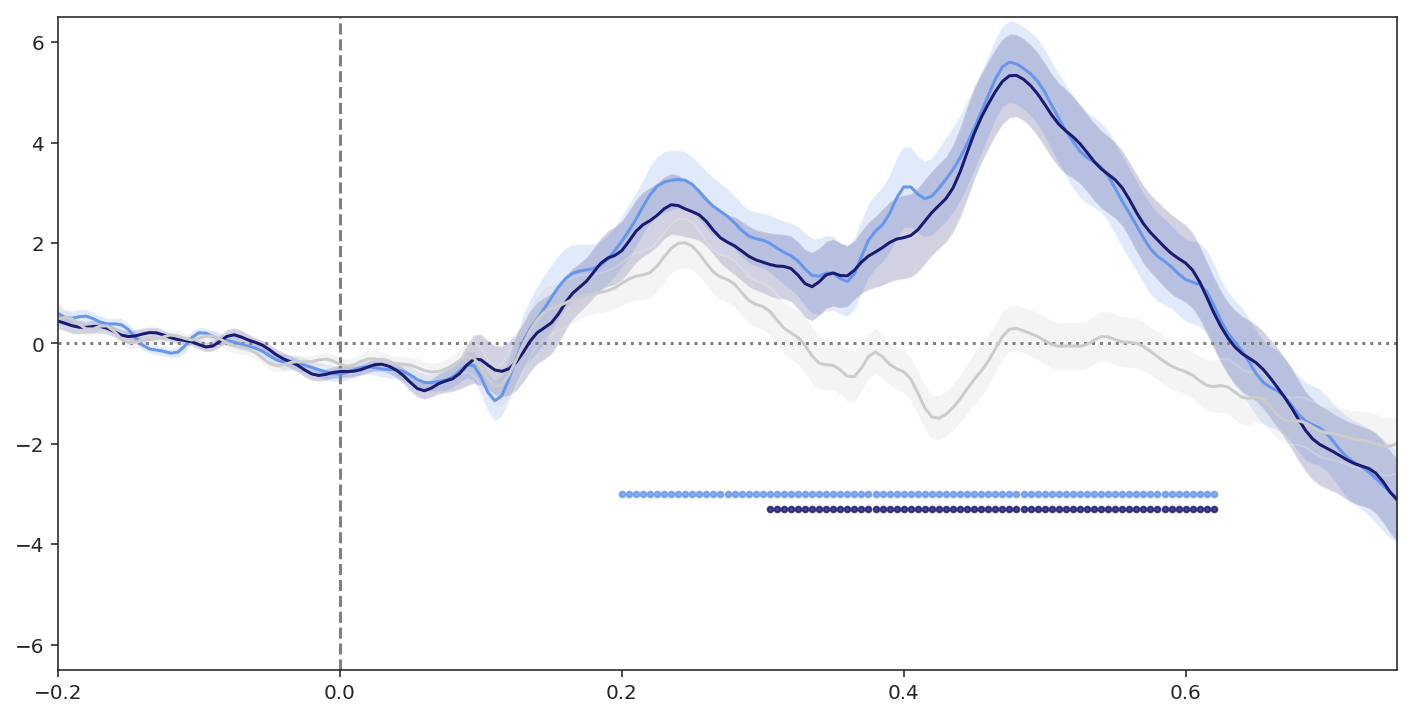

In [10]:
#Now the plotting, first lets do the P3
easy_data_P3_scaled = [x * 10**6 for x in easy_data_P3]
diff_data_P3_scaled = [x * 10**6 for x in diff_data_P3]
neut_data_P3_scaled = [x * 10**6 for x in neut_data_P3]

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(12, 6))
ax.axhline(0, color='grey', linestyle=':')
ax.axvline(0, color='grey', linestyle='--')
ax.set_ylim([-6.5, 6.5])
colors = {'Easy Cue': easyColor,'Difficult Cue': diffColor , 'Neutral Cue': neutColor}

sns.tsplot(easy_data_P3_scaled, time=times, color=colors, ci=[68], condition = 'Easy Cue', legend = False)
sns.tsplot(diff_data_P3_scaled, time=times, color=colors, ci=[68], condition = 'Difficult Cue',legend = False)
sns.tsplot(neut_data_P3_scaled, time=times, color=colors, ci=[68], condition = 'Neutral Cue',legend = False)

sns.regplot(x = e_p3_mask_05, y=np.ones(e_p3_mask_05.shape)*-3, fit_reg=False, color = easyColor, scatter_kws ={'s':8})
sns.regplot(x = d_p3_mask_05, y=np.ones(d_p3_mask_05.shape)*-3.3, fit_reg=False, color = diffColor, scatter_kws ={'s':8})


#fig.savefig('/home/sage/Dropbox/Sage/tdPlots/P3_l2c.png', format = 'png', dpi = 1000)


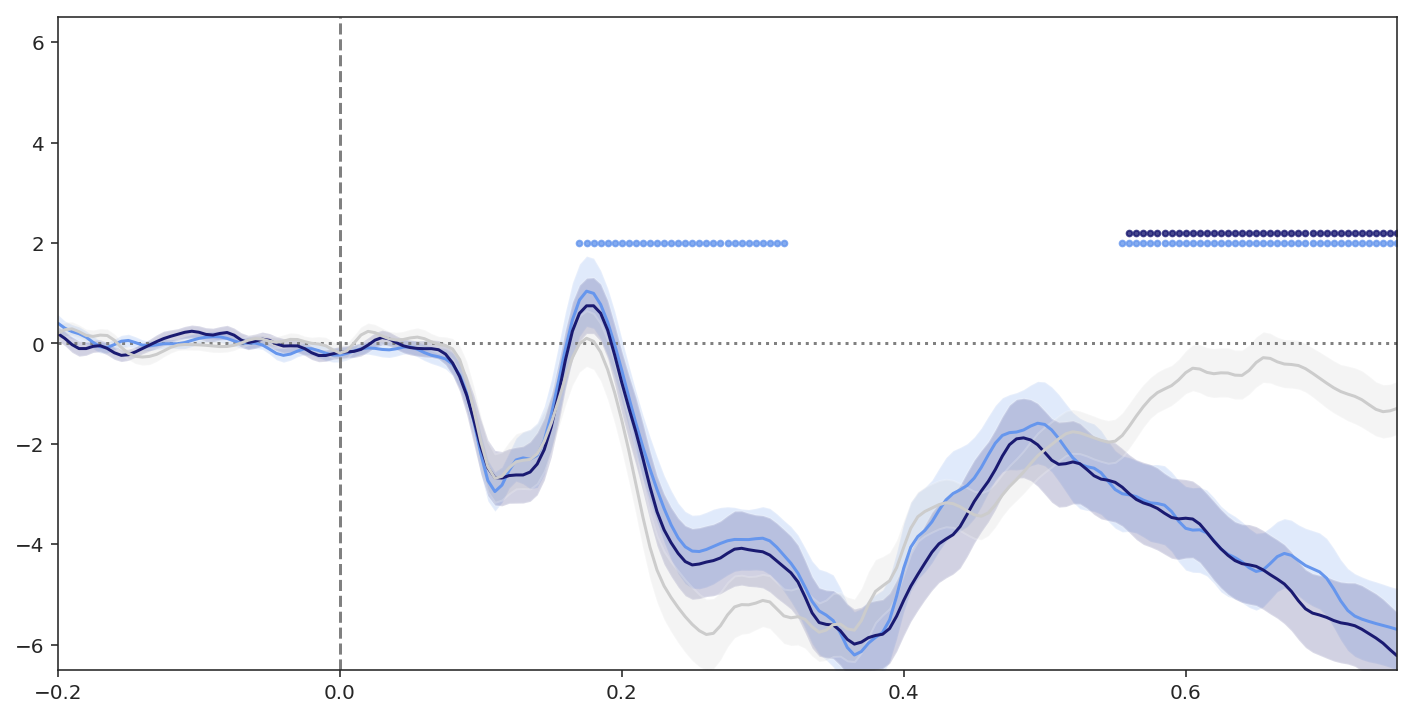

In [11]:
#Next the cnv
easy_data_cnv_scaled = [x * 10**6 for x in easy_data_cnv]
diff_data_cnv_scaled = [x * 10**6 for x in diff_data_cnv]
neut_data_cnv_scaled = [x * 10**6 for x in neut_data_cnv]

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(12, 6))
ax.axhline(0, color='grey', linestyle=':')
ax.axvline(0, color='grey', linestyle='--')
ax.set_ylim([-6.5, 6.5])

colors = {'Easy Cue': easyColor,'Difficult Cue': diffColor , 'Neutral Cue': neutColor}

sns.tsplot(easy_data_cnv_scaled, time=times, color=colors, ci=[68], condition = 'Easy Cue', legend = False)
sns.tsplot(diff_data_cnv_scaled, time=times, color=colors, ci=[68], condition = 'Difficult Cue', legend = False)
sns.tsplot(neut_data_cnv_scaled, time=times, color=colors, ci=[68], condition = 'Neutral Cue', legend = False)

sns.regplot(x = e_cnv_mask_05, y=np.ones(e_cnv_mask_05.shape)*2, fit_reg=False, color = easyColor, scatter_kws ={'s':8})
sns.regplot(x = d_cnv_mask_05, y=np.ones(d_cnv_mask_05.shape)*2.2, fit_reg=False, color = diffColor, scatter_kws ={'s':8})


#fig.savefig('/home/sage/Dropbox/Sage/tdPlots/CNV_l2c.png', format = 'png', dpi = 1000)


# Time Frequency

In [12]:
#load up the longer epochs and combine the cue conditions

conds     = ['Easy Cue', 'Difficult Cue', 'Neutral Cue']
triggers  = [30, 40, 50]
event_ids = dict(zip(conds, triggers))
addon     = '_longEpo'
# load the epoched data
all_epochs_long = []
for ii, name in enumerate(sorted(subjs)):
    print('starting ' + name)
    if name not in bad_subjs:
        epochs = mne.read_epochs(out_template.format(name + addon, "arvepo"), verbose='error')
        epochs.events[np.in1d(epochs.events[:,2], [71,72,73,74]),2] = 50 #combine all the neutral cue trials
        epochs.events[np.in1d(epochs.events[:,2], [23, 43]),2]      = 30 #combine the easy cue trials
        epochs.events[np.in1d(epochs.events[:,2], [24, 44]),2]      = 40 #and the difficult cue trials
        
        
        epochs.event_id = event_ids
        epochs.equalize_event_counts(event_ids=event_ids)
        print(epochs)
        all_epochs_long.append(epochs)
print(len(all_epochs_long))

starting s01_task
<EpochsFIF  |   627 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~70.5 MB, data loaded,
 'Difficult Cue': 209
 'Easy Cue': 209
 'Neutral Cue': 209>
starting s02_task
<EpochsFIF  |   669 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~75.2 MB, data loaded,
 'Difficult Cue': 223
 'Easy Cue': 223
 'Neutral Cue': 223>
starting s03_task
<EpochsFIF  |   645 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~72.5 MB, data loaded,
 'Difficult Cue': 215
 'Easy Cue': 215
 'Neutral Cue': 215>
starting s04_task
<EpochsFIF  |   600 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~67.5 MB, data loaded,
 'Difficult Cue': 200
 'Easy Cue': 200
 'Neutral Cue': 200>
starting s05_task
<EpochsFIF  |   618 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~69.5 MB, data loaded,
 'Difficult Cue': 206
 'Easy Cue': 206
 'Neutral Cue': 206>
starting s06_task
<EpochsFIF  |   645 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~72.5 MB, data loaded,
 'Difficult Cue'

In [13]:
# Check if the sub already has a tfr for each condition if they 
# dont, make one, if they do, load it up and add it to the power list

overwrite = False

conds     = ['Easy Cue', 'Difficult Cue', 'Neutral Cue']
power     = {cond:[] for cond in sorted(conds)}

freqs     = np.asarray(range(3,40)) # define frequencies of interest
n_cycles  = freqs *.4  # (T = n_cycles / freq) so this is a 300ms time window

for sub in range(numSubs):
    print('Starting ' + subjs[sub])
    tfr = []
    for cond in conds:
        print(cond)
        fname = sourceloc + 'tfr/' + subjs[sub] + '_' + cond[:3] + '-tfr.h5'

        if  not(os.path.exists(fname)) or overwrite == True:
            tfr_cur   = tfr_morlet(all_epochs_long[sub][cond], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4)
            tfr_cur.save(fname, overwrite=overwrite)
        else: 
            tfr_cur = mne.time_frequency.read_tfrs(fname=fname)[0]
            
        power[cond].append(tfr_cur)


    power['Difficult Cue'][sub].data = (power['Difficult Cue'][sub].data - power['Neutral Cue'][sub].data) / (power['Difficult Cue'][sub].data + power['Neutral Cue'][sub].data) *100
    power['Easy Cue'][sub].data = (power['Easy Cue'][sub].data - power['Neutral Cue'][sub].data) / (power['Easy Cue'][sub].data + power['Neutral Cue'][sub].data) *100
    power['Neutral Cue'][sub].data = (power['Difficult Cue'][sub].data - power['Easy Cue'][sub].data) / (power['Difficult Cue'][sub].data + power['Easy Cue'][sub].data) *100

print('done')

Starting s01_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s02_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s03_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s04_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s05_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s06_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s07_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s08_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s09_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s10_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s11_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s12_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s13_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s14_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s15_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s16_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s17_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s19_task
Easy Cue
Difficult Cue
Neutral Cue
Starting s20_task
Easy Cue
Difficult Cue
Neutr

In [14]:
#Create an average across subjects in order to plot the topo
pwr_EC_data  = []
pwr_DC_data  = []
pwr_int_data = []
pwr_avg_data = []

for sub in range(numSubs):    
    pwr_EC_data.append(power['Easy Cue'][sub].data);
    pwr_DC_data.append(power['Difficult Cue'][sub].data);
    pwr_int_data.append(power['Neutral Cue'][sub].data)
    pwr_avg_data.append(((power['Easy Cue'][sub].data + power['Difficult Cue'][sub].data) /2))
    

pwr_EC_avg  = np.mean(pwr_EC_data,0)
pwr_DC_avg  = np.mean(pwr_DC_data,0)
pwr_int_avg = np.mean(pwr_int_data,0)
pwr_avg_avg = np.mean(pwr_avg_data,0)

#Create a copy of the evoked structure and then replace the data witht the average data
pwr_EC  = copy.deepcopy(power['Easy Cue'][0])
pwr_DC  = copy.deepcopy(power['Difficult Cue'][0])
pwr_int = copy.deepcopy(power['Neutral Cue'][0])
pwr_avg = copy.deepcopy(power['Easy Cue'][0])

pwr_EC.data  = pwr_EC_avg
pwr_DC.data  = pwr_DC_avg
pwr_int.data = pwr_int_avg
pwr_avg.data = pwr_avg_avg

In [15]:
#Create an average across subjects in order to plot the topo
elecs = ['P3','P2', 'Pz', 'P1','P3','PO8' 'PO4', 'POz', 'PO3','PO7', 'O1', 'Oz', 'O2']

times = power['Easy Cue'][0].times
freqs = power['Easy Cue'][0].freqs

pwr_EC_data  = []
pwr_DC_data  = []
pwr_int_data = []
pwr_avg_data = []

#also store an average time series between 8 and 12 Hz (5&9 in array)
alphaTS_EC_data = []
alphaTS_DC_data = []
alphaTS_int_data = []

for sub in range(numSubs):
    tmpEC  = copy.deepcopy(power['Easy Cue'][sub])
    tmpDC  = copy.deepcopy(power['Difficult Cue'][sub])
    tmpint = copy.deepcopy(power['Neutral Cue'][sub])
    tmpavg = copy.deepcopy(power['Easy Cue'][sub])
    
    sub_e_data = np.mean(tmpEC.pick_channels(elecs).data,0)
    sub_d_data = np.mean(tmpDC.pick_channels(elecs).data,0)
    sub_i_data = np.mean(tmpDC.pick_channels(elecs).data,0) - np.mean(tmpEC.pick_channels(elecs).data,0) 
    sub_a_data = ((np.mean(tmpEC.pick_channels(elecs).data,0) + np.mean(tmpDC.pick_channels(elecs).data,0)) /2)
    
    sub_e_data = scipy.ndimage.gaussian_filter(sub_e_data,sigma=.5)
    sub_d_data = scipy.ndimage.gaussian_filter(sub_d_data,sigma=.5)
    sub_i_data = scipy.ndimage.gaussian_filter(sub_i_data,sigma=.5)
    sub_a_data = scipy.ndimage.gaussian_filter(sub_a_data, sigma=.5)
    
    pwr_EC_data.append(sub_e_data);
    pwr_DC_data.append(sub_d_data);
    pwr_int_data.append(sub_i_data);
    pwr_avg_data.append(sub_a_data);
    
    sub_e_alphaTS = np.mean(sub_e_data[5:9],0)
    sub_d_alphaTS = np.mean(sub_d_data[5:9],0)
    sub_i_alphaTS = np.mean(sub_i_data[5:9],0)
    
    alphaTS_EC_data.append(sub_e_alphaTS);
    alphaTS_DC_data.append(sub_d_alphaTS);
    alphaTS_int_data.append(sub_i_alphaTS);

pwr_EC_avg  = np.mean(pwr_EC_data,0)
pwr_DC_avg  = np.mean(pwr_DC_data,0)
pwr_int_avg = np.mean(pwr_int_data,0)
pwr_avg_avg = np.mean(pwr_avg_data,0)

### stats

In [16]:
# run cluster test vs 0 and vs each other
t_e_alpha, clusters_e_alpha, cluster_pv_e_alpha, H0_e_alpha             = permutation_cluster_1samp_test(np.asarray(pwr_EC_data), out_type = 'mask')
t_d_alpha, clusters_d_alpha, cluster_pv_d_alpha, H0_d_alpha             = permutation_cluster_1samp_test(np.asarray(pwr_DC_data), out_type = 'mask')
t_int_alpha, clusters_int_alpha, cluster_pv_int_alpha, H0_int_alpha     = permutation_cluster_1samp_test(np.asarray(pwr_int_data), out_type = 'mask')
t_avg_alpha, clusters_avg_alpha, cluster_pv_avg_alpha, H0_avg_alpha        = permutation_cluster_1samp_test(np.asarray(pwr_avg_data), out_type = 'mask')

mask_alpha_e_05   = np.asarray(clusters_e_alpha)[cluster_pv_e_alpha<.05]
mask_alpha_d_05   = np.asarray(clusters_d_alpha)[cluster_pv_d_alpha<.05]
mask_alpha_int_05 = np.asarray(clusters_int_alpha)[cluster_pv_int_alpha<.05]
mask_alpha_avg_05 = np.asarray(clusters_avg_alpha)[cluster_pv_avg_alpha<.05]

In [17]:
alphaTS_diff_data = np.asarray(alphaTS_DC_data) - np.asarray(alphaTS_EC_data)
t_eTS_alpha, clusters_eTS_alpha, cluster_pv_eTS_alpha, H0_eTS_alpha             = permutation_cluster_1samp_test(np.asarray(alphaTS_EC_data))
t_dTS_alpha, clusters_dTS_alpha, cluster_pv_dTS_alpha, H0_dTS_alpha             = permutation_cluster_1samp_test(np.asarray(alphaTS_DC_data))
t_iTS_alpha, clusters_iTS_alpha, cluster_pv_iTS_alpha, H0_iTS_alpha             = permutation_cluster_1samp_test(np.asarray(alphaTS_diff_data))

In [18]:
##Alpha of .05

# get arrays of siginficant clusters for easy vs o
e_TS_mask_05 = []
sig_times = np.asarray(clusters_eTS_alpha)[cluster_pv_eTS_alpha<.05]
for i in range(len(sig_times)):
    e_TS_mask_05 = np.append(e_TS_mask_05,(times[sig_times[i][0]]))


# get arrays of siginficant clusters for difficult vs o
d_TS_mask_05 = []
sig_times = np.asarray(clusters_dTS_alpha)[cluster_pv_dTS_alpha<.05]
for i in range(len(sig_times)):
    d_TS_mask_05 = np.append(d_TS_mask_05,(times[sig_times[i][0]]))

### plots

#### plot averages

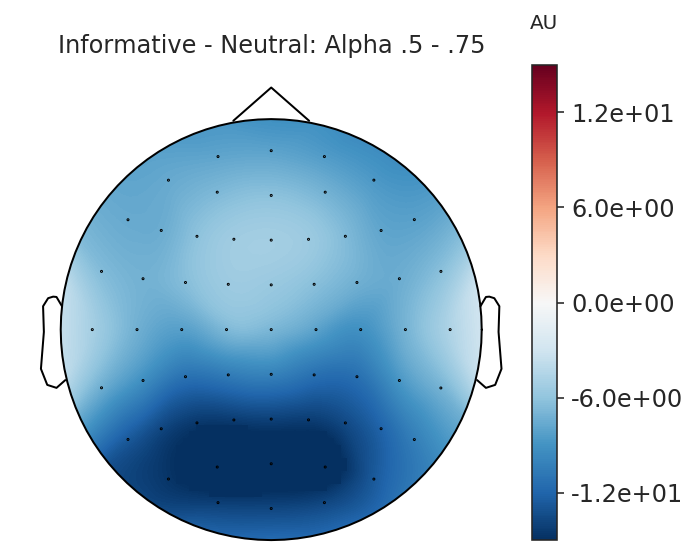

In [19]:
vmin, vmax = -15, 15
#fig, axis = plt.subplots(figsize=(12, 4))
fig, ax = plt.subplots(figsize=(6, 4))

pwr_avg.plot_topomap(tmin=.5, tmax=.75, fmin=8, fmax=12, vmin = vmin, vmax = vmax, axes= ax, title = 'Informative - Neutral: Alpha .5 - .75', show = False, contours = 0);


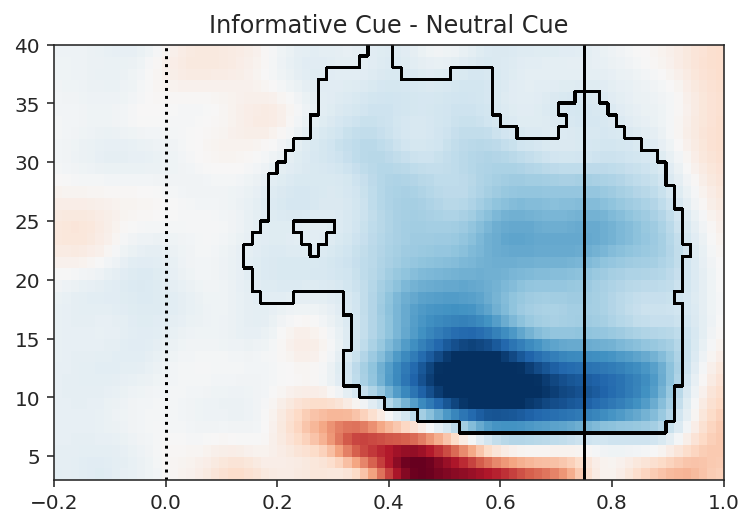

In [20]:
# Informative - Neutral
fig, axis = plt.subplots(figsize=(6, 4))
extent=(-.2, 1, 3, 40)

#Easy

im = axis.imshow(pwr_avg_avg, cmap = 'RdBu_r', vmin = -15, vmax = 15, extent=extent, origin="lower", aspect="auto");
#plt.colorbar(im)

#Add significance contour
big_mask = np.kron(np.squeeze(mask_alpha_avg_05), np.ones((10,10))) #interpolate to 10x real data to fix contours
axis.contour(big_mask, colors='black', extent=extent, 
             linewidths=.75, corner_mask=False, antialiased=False)

axis.axvline(x = 0, color = 'k', linestyle = ':')
axis.axvline(x = .75, color = 'k')

axis.title.set_text('Informative Cue - Neutral Cue')

#### plot seperate for difficulty

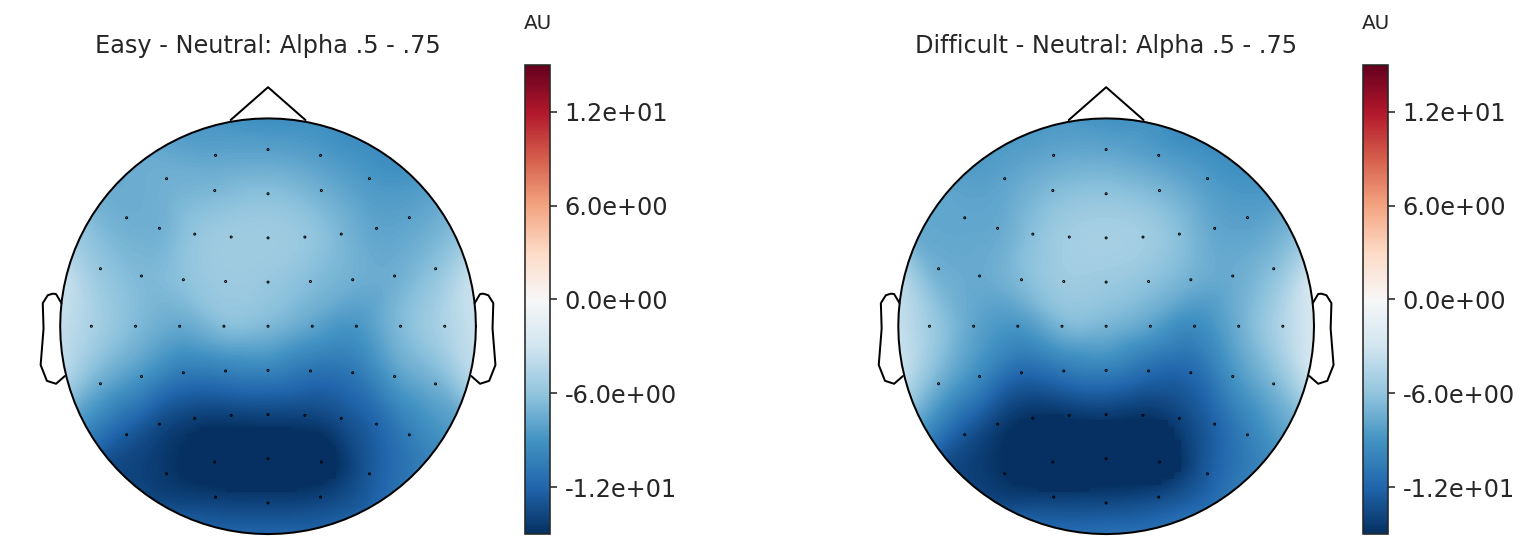

In [21]:
#Plot Alpha 
vmin, vmax = -15, 15
fig, axis = plt.subplots(1,2, figsize=(12, 4))

pwr_EC.plot_topomap(tmin=.5, tmax=.75, fmin=8, fmax=12, vmin = vmin, vmax = vmax, title = 'Easy - Neutral: Alpha .5 - .75', axes= axis[0], show = False, contours = 0)
pwr_DC.plot_topomap(tmin=.5, tmax=.75, fmin=8, fmax=12, vmin = vmin, vmax = vmax, title = 'Difficult - Neutral: Alpha .5 - .75', axes= axis[1], show = False, contours = 0)

mne.viz.tight_layout()
plt.show()

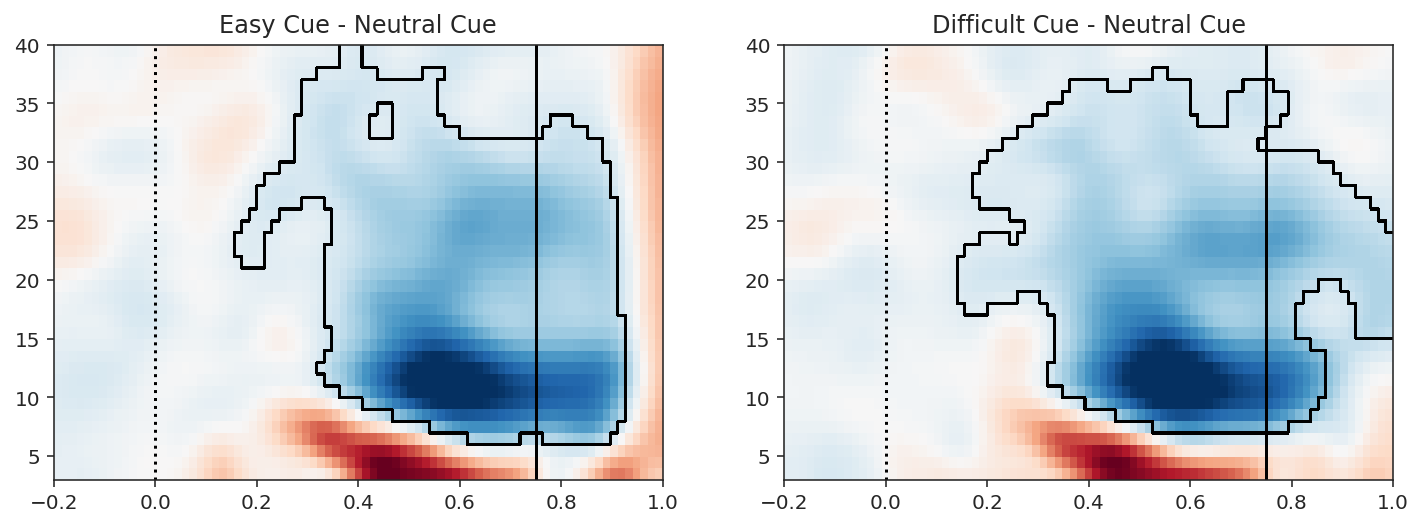

In [28]:
# Easy - Neutral
fig, axis = plt.subplots(1,2, figsize=(12, 4))
extent=(-.2, 1, 3, 40)

#Easy

im = axis[0].imshow(pwr_EC_avg, cmap = 'RdBu_r', vmin = -15, vmax = 15, extent=extent, origin="lower", aspect="auto");
#plt.colorbar(im)

#Add significance contour
big_mask = np.kron(np.squeeze(mask_alpha_e_05), np.ones((10,10))) #interpolate to 10x real data to fix contours
axis[0].contour(big_mask, colors='black', extent=extent, 
             linewidths=.75, corner_mask=False, antialiased=False)

axis[0].axvline(x = 0, color = 'k', linestyle = ':')
axis[0].axvline(x = .75, color = 'k')

axis[0].title.set_text('Easy Cue - Neutral Cue')

# Difficult

im = axis[1].imshow(pwr_DC_avg, cmap = 'RdBu_r', vmin = -15, vmax = 15, extent=extent, origin="lower", aspect="auto");

#Add significance contour
big_mask = np.kron(np.squeeze(mask_alpha_d_05), np.ones((10,10))) #interpolate to 10x real data to fix contours
axis[1].contour(big_mask, colors='black', extent=extent, 
             linewidths=.75, corner_mask=False, antialiased=False)

axis[1].axvline(x = 0, color = 'k', linestyle = ':')
axis[1].axvline(x = .75, color = 'k')

axis[1].title.set_text('Difficult Cue - Neutral Cue')

#fig.savefig('/home/sage/Dropbox/Sage/tdPlots/alpha_Easy.png', format = 'png', dpi = 1000)

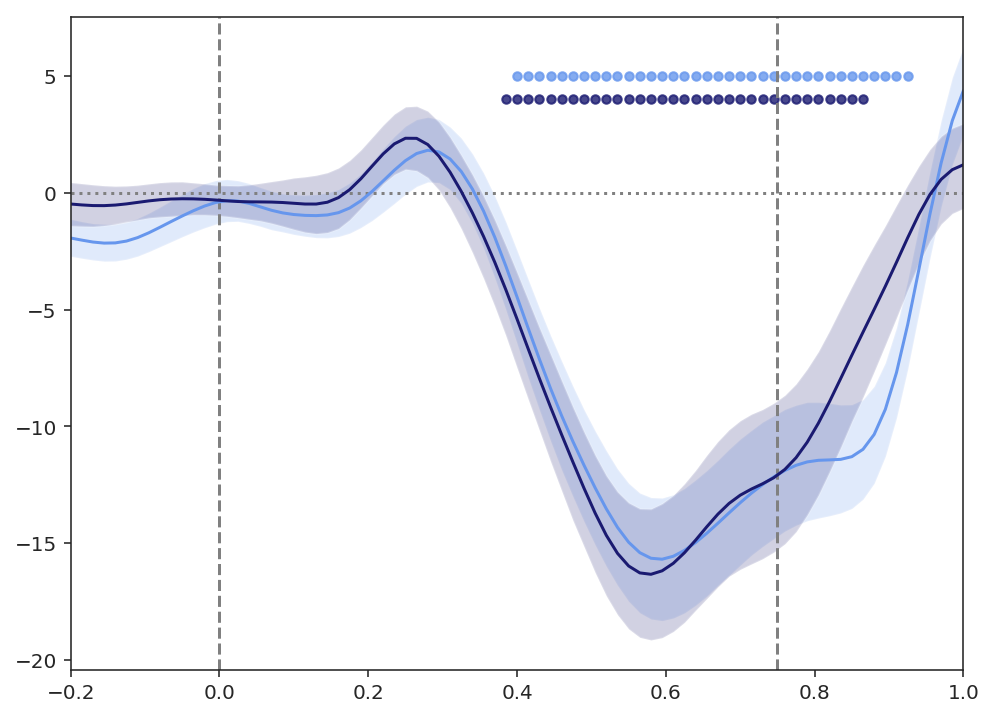

In [23]:
#Next the timecourse
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(0, color='grey', linestyle=':')
ax.axvline(0, color='grey', linestyle='--')
ax.axvline(.75, color='grey', linestyle='--')


colors = {'Easy Cue': easyColor,'Difficult Cue': diffColor}

sns.tsplot(alphaTS_EC_data, time=times, color=colors, ci=[68], condition = 'Easy Cue', legend = False)
sns.tsplot(alphaTS_DC_data, time=times, color=colors, ci=[68], condition = 'Difficult Cue', legend = False)

sns.regplot(x = d_TS_mask_05, y=np.ones(d_TS_mask_05.shape)*4, fit_reg=False, color = diffColor, scatter_kws ={'s':18})
sns.regplot(x = e_TS_mask_05, y=np.ones(e_TS_mask_05.shape)*5, fit_reg=False, color = easyColor, scatter_kws ={'s':18})



#### interaction

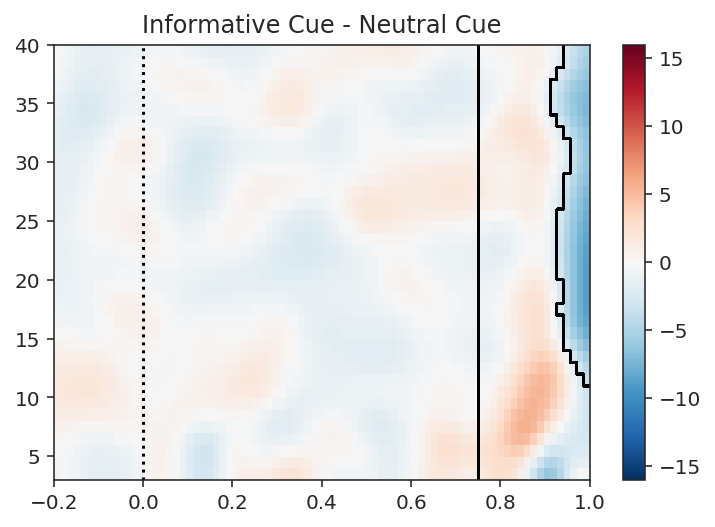

In [38]:
# Informative - Neutral
fig, axis = plt.subplots(figsize=(6, 4))
extent=(-.2, 1, 3, 40)

#Easy

im = axis.imshow(pwr_int_avg, cmap = 'RdBu_r', vmin = -16, vmax = 16, extent=extent, origin="lower", aspect="auto");
plt.colorbar(im)

#Add significance contour
big_mask = np.kron(np.squeeze(mask_alpha_int_05), np.ones((10,10))) #interpolate to 10x real data to fix contours
axis.contour(big_mask, colors='black', extent=extent, 
             linewidths=.75, corner_mask=False, antialiased=False)

axis.axvline(x = 0, color = 'k', linestyle = ':')
axis.axvline(x = .75, color = 'k')

axis.title.set_text('Informative Cue - Neutral Cue')

### Beta vs. Alpha

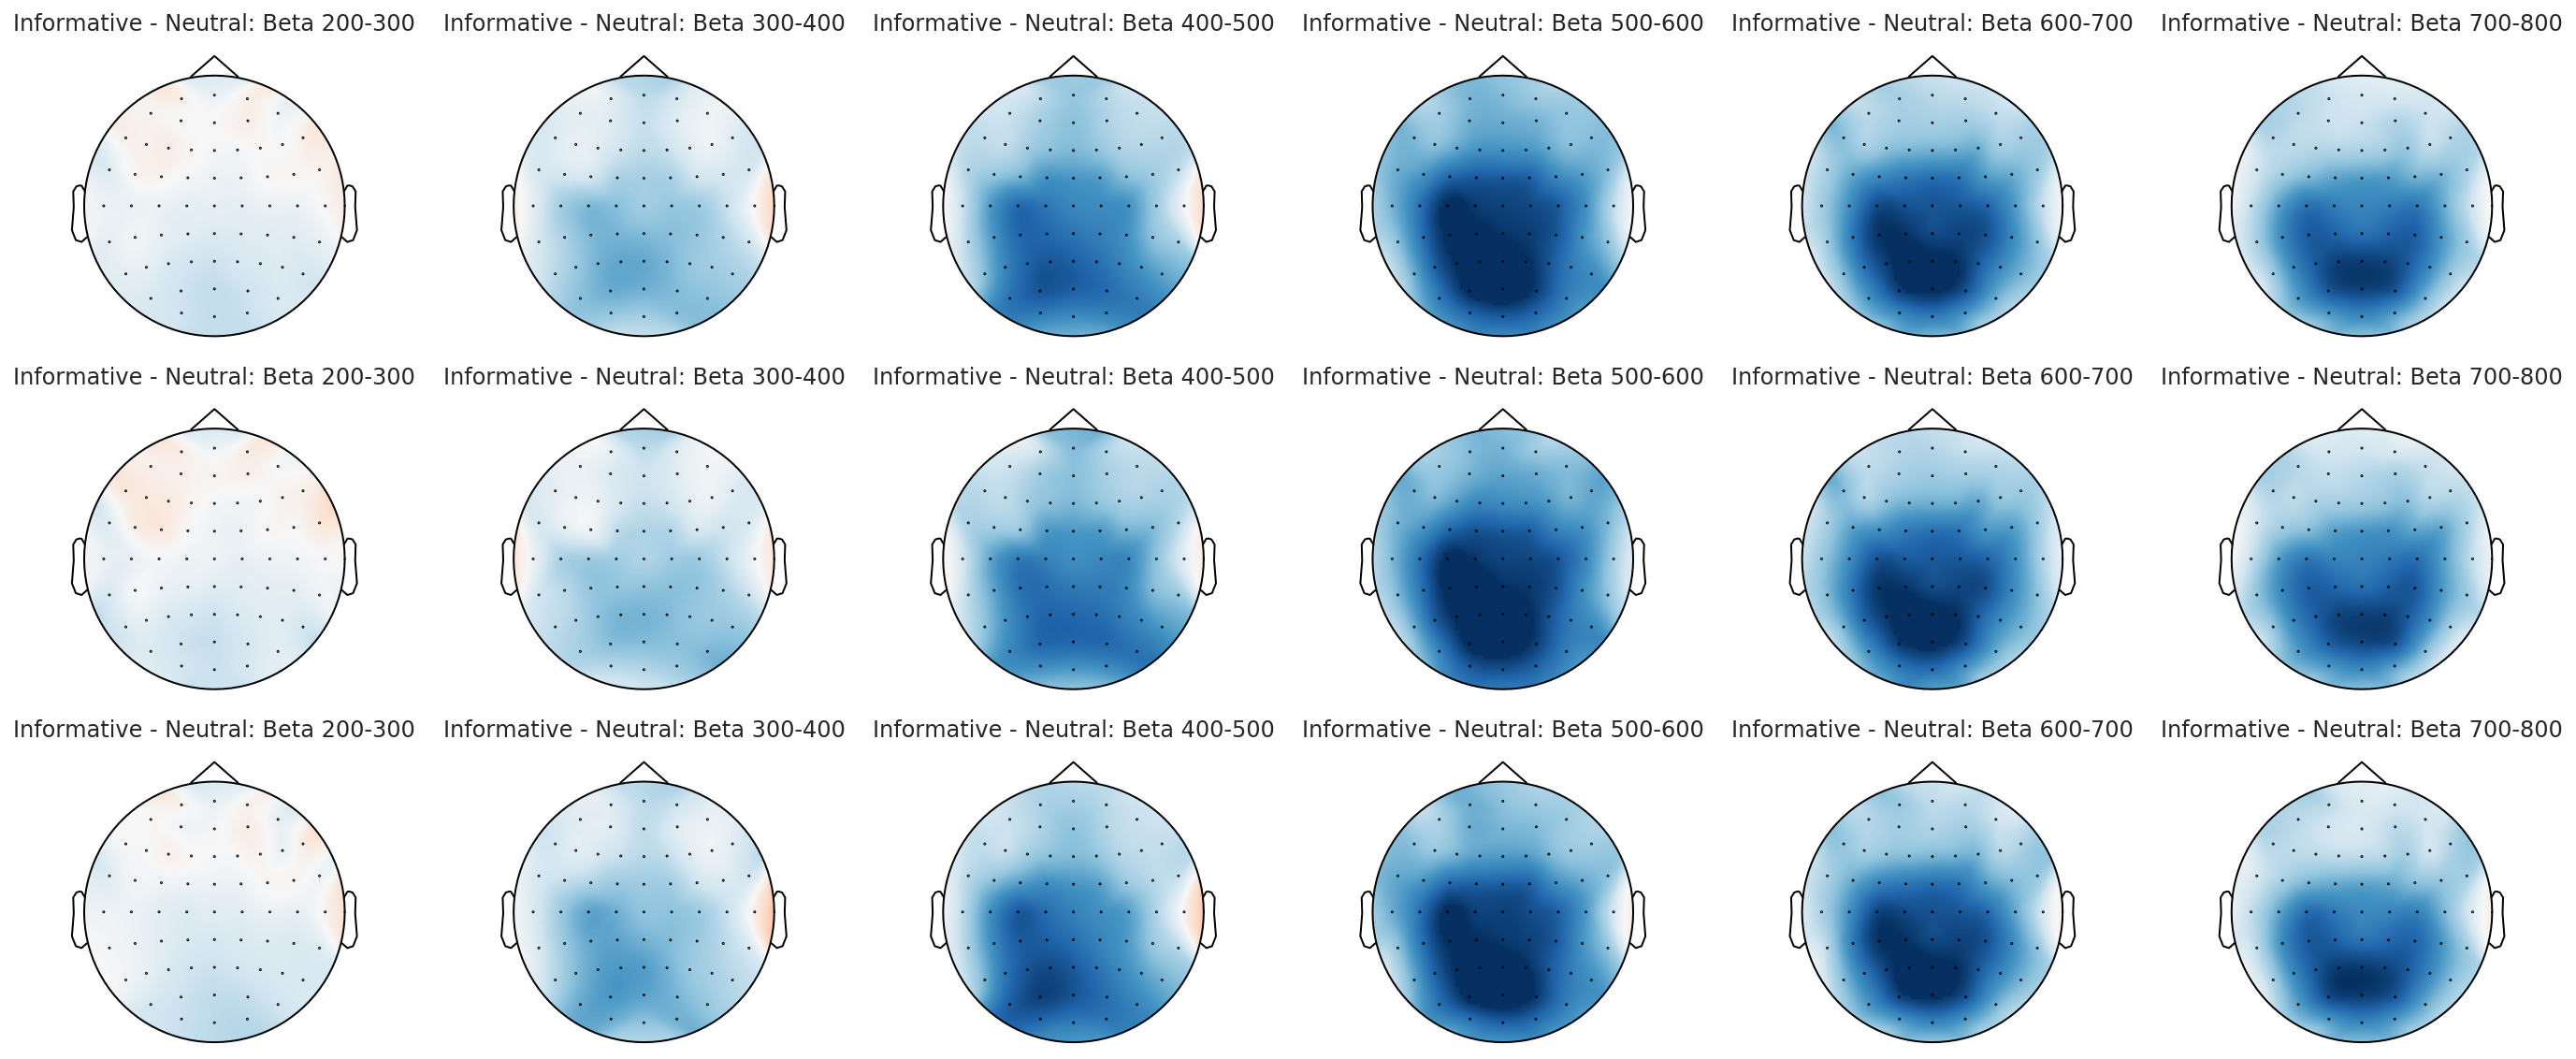

In [35]:
#Beta
vmin    = -8
vmax    = 8

fig, ax      = plt.subplots(ncols=6, nrows=3, figsize=(24, 9))
times        = [(.2,.3), (.3,.4), (.4,.5), (.5,.6), (.6,.7), (.7,.8)]

for i in range(6):
    pwr_avg.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=13, fmax=30, vmin = vmin, vmax = vmax, axes= ax[0,i], title = 'Informative - Neutral: Beta ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);
    pwr_EC.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=13, fmax=30, vmin = vmin, vmax = vmax, axes= ax[1,i], title = 'Informative - Neutral: Beta ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);
    pwr_DC.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=13, fmax=30, vmin = vmin, vmax = vmax, axes= ax[2,i], title = 'Informative - Neutral: Beta ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);


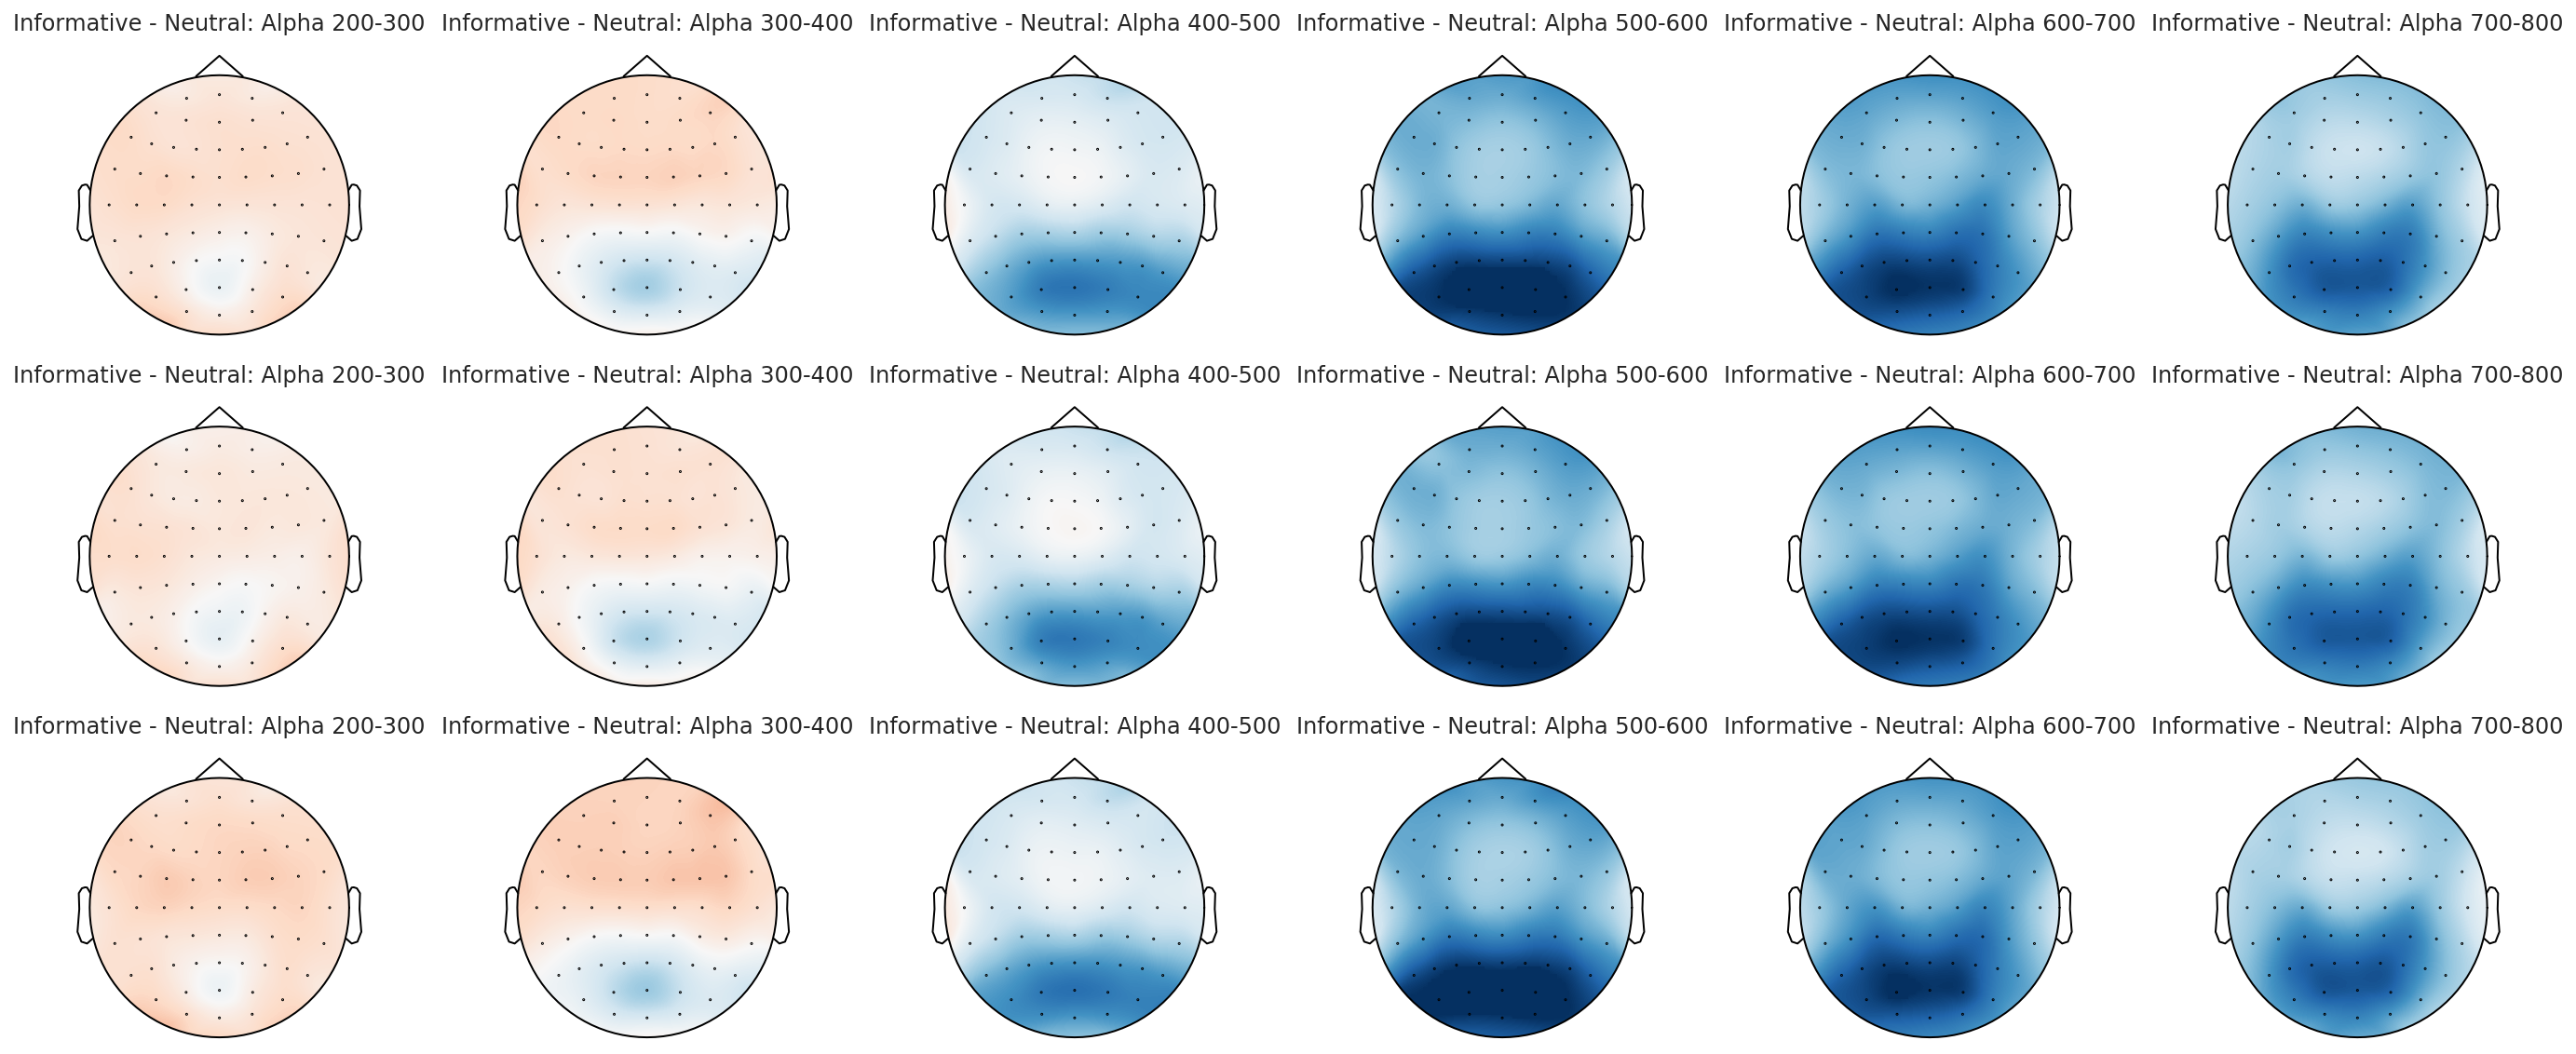

In [37]:
vmin    = -16
vmax    = 16

fig, ax      = plt.subplots(ncols=6, nrows=3, figsize=(24, 9))
times        = [(.2,.3), (.3,.4), (.4,.5), (.5,.6), (.6,.7), (.7,.8)]

for i in range(6):
    pwr_avg.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=8, fmax=12, vmin = vmin, vmax = vmax, axes= ax[0,i], title = 'Informative - Neutral: Alpha ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);
    pwr_EC.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=8, fmax=12, vmin = vmin, vmax = vmax, axes= ax[1,i], title = 'Informative - Neutral: Alpha ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);
    pwr_DC.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=8, fmax=12, vmin = vmin, vmax = vmax, axes= ax[2,i], title = 'Informative - Neutral: Alpha ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);
